#### 1.Import Library

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import os
import random
import glob
import re
from torch import no_grad
from torch import tensor
from torch.nn import Softmax
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.cuda import is_available
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import gc
import pickle
import sys
import psutil
MODEL_NAME = "bert-base-uncased"

#### 2. Import and Analysis Data

In [2]:
train_data = pd.read_csv('./data/train.csv',index_col='id')
train_data

keyword  \
id                             
1                        NaN   
4                        NaN   
5                        NaN   
6                        NaN   
7                        NaN   
8                        NaN   
10                       NaN   
13                       NaN   
14                       NaN   
15                       NaN   
16                       NaN   
17                       NaN   
18                       NaN   
19                       NaN   
20                       NaN   
23                       NaN   
24                       NaN   
25                       NaN   
26                       NaN   
28                       NaN   
31                       NaN   
32                       NaN   
33                       NaN   
34                       NaN   
36                       NaN   
37                       NaN   
38                       NaN   
39                       NaN   
40                       NaN   
41                       NaN   
44                       NaN   
48                    ablaze   
49                    ablaze   
50                    ablaze   
52                    ablaze   
53                    ablaze   
54                    ablaze   
55                    ablaze   
56                    ablaze   
57                    ablaze   
59                    ablaze   
61                    ablaze   
62                    ablaze   
63                    ablaze   
64                    ablaze   
65                    ablaze   
66                    ablaze   
67                    ablaze   
68                    ablaze   
71                    ablaze   
73                    ablaze   
74                    ablaze   
76                    ablaze   
77                    ablaze   
78                    ablaze   
79                    ablaze   
80                    ablaze   
81                    ablaze   
82                    ablaze   
83                    ablaze   
85                    ablaze   
86                    ablaze   
89                    ablaze   
91                    ablaze   
92                    ablaze   
93                    ablaze   
95                    ablaze   
96                  accident   
97                  accident   
98                  accident   
100                 accident   
102                 accident   
104                 accident   
105                 accident   
107                 accident   
109                 accident   
110                 accident   
112                 accident   
113                 accident   
114                 accident   
117                 accident   
118                 accident   
119                 accident   
120                 accident   
121                 accident   
126                 accident   
128                 accident   
129                 accident   
130                 accident   
131                 accident   
132                 accident   
133                 accident   
134                 accident   
135                 accident   
136                 accident   
137                 accident   
138                 accident   
139                 accident   
141                 accident   
143                 accident   
144                 accident   
145                 accident   
146               aftershock   
149               aftershock   
151               aftershock   
153               aftershock   
156               aftershock   
157               aftershock   
158               aftershock   
159               aftershock   
160               aftershock   
161               aftershock   
162               aftershock   
163               aftershock   
164               aftershock   
165               aftershock   
168               aftershock   
170               aftershock   
171               aftershock   
172               aftershock   
173               aftershock   
174               aftershock   
175               aftershock   
176               aft

In [3]:
test_data = pd.read_csv('./data/test.csv',index_col='id')
test_data

keyword                                    location  \
id                                                                         
0                        NaN                                         NaN   
2                        NaN                                         NaN   
3                        NaN                                         NaN   
9                        NaN                                         NaN   
11                       NaN                                         NaN   
12                       NaN                                         NaN   
21                       NaN                                         NaN   
22                       NaN                                         NaN   
27                       NaN                                         NaN   
29                       NaN                                         NaN   
30                       NaN                                         NaN   
35                       NaN                                         NaN   
42                       NaN                                         NaN   
43                       NaN                                         NaN   
45                       NaN                                         NaN   
46                    ablaze                                      London   
47                    ablaze              Niall's place | SAF 12 SQUAD |   
51                    ablaze                                     NIGERIA   
58                    ablaze                              Live On Webcam   
60                    ablaze                    Los Angeles, Califnordia   
69                    ablaze                              threeonefive.    
70                    ablaze                            Washington State   
72                    ablaze                          Whoop Ass, Georgia   
75                    ablaze                                       India   
84                    ablaze                                         NaN   
87                    ablaze                        scarborough, ontario   
88                    ablaze                                         NaN   
90                    ablaze                121 N La Salle St, Suite 500   
94                    ablaze                                   Wandering   
99                  accident                                Homewood, PA   
101                 accident                                         NaN   
103                 accident                                         NaN   
106                 accident                                         USA   
108                 accident                               Massachusetts   
111                 accident                                     Bexhill   
115                 accident                                 Anime World   
116                 accident                                         NaN   
122                 accident                          Cowtown, Caliii !!   
123                 accident                                         NaN   
124                 accident                           All Motorways, UK   
125                 accident                          Frankfurt, Germany   
127                 accident                                 Gresham, OR   
140                 accident                                         NaN   
142                 accident                                  Las Vegas    
147               aftershock                                 Midland, Mi   
148               aftershock                    SÌ£o Vicente, SÌ£o Paulo   
150               aftershock                          Vault 101, Fallout   
152               aftershock                                 Switzerland   
154               aftershock                                  California   
155               aftershock                                      Europe   
166               aftershock                                         

In [4]:
# process useless info and concat data
for df in [train_data,test_data]:
    # replace url, user, number, blank, %20
    df['text'] = df['text'].apply(lambda x:re.sub(r'https?://[A-Za-z0-9/:.]+','*',x))
    df['text'] = df['text'].apply(lambda x:re.sub(r'@[A-Za-z0-9/:._]+','@user',x))
    df['text'] = df['text'].apply(lambda x:re.sub(r'[0-9]+','0',x))
    df['text'] = df['text'].apply(lambda x:re.sub(r'\s+',' ',x))
    df['keyword'] = df['keyword'].str.replace('%20','_')
    # text + '#' + keyword
    df['text'] = df['text'] + df['keyword'].apply(lambda x: ' #' + x if not(x is np.nan) else '' )

In [5]:
print(train_data['keyword'].nunique(),test_data['keyword'].nunique())

221 221


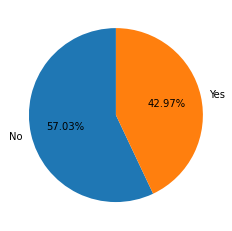

In [6]:
plt.pie(train_data['target'].value_counts(),labels=['No','Yes'],startangle=90,autopct='%.2f%%');

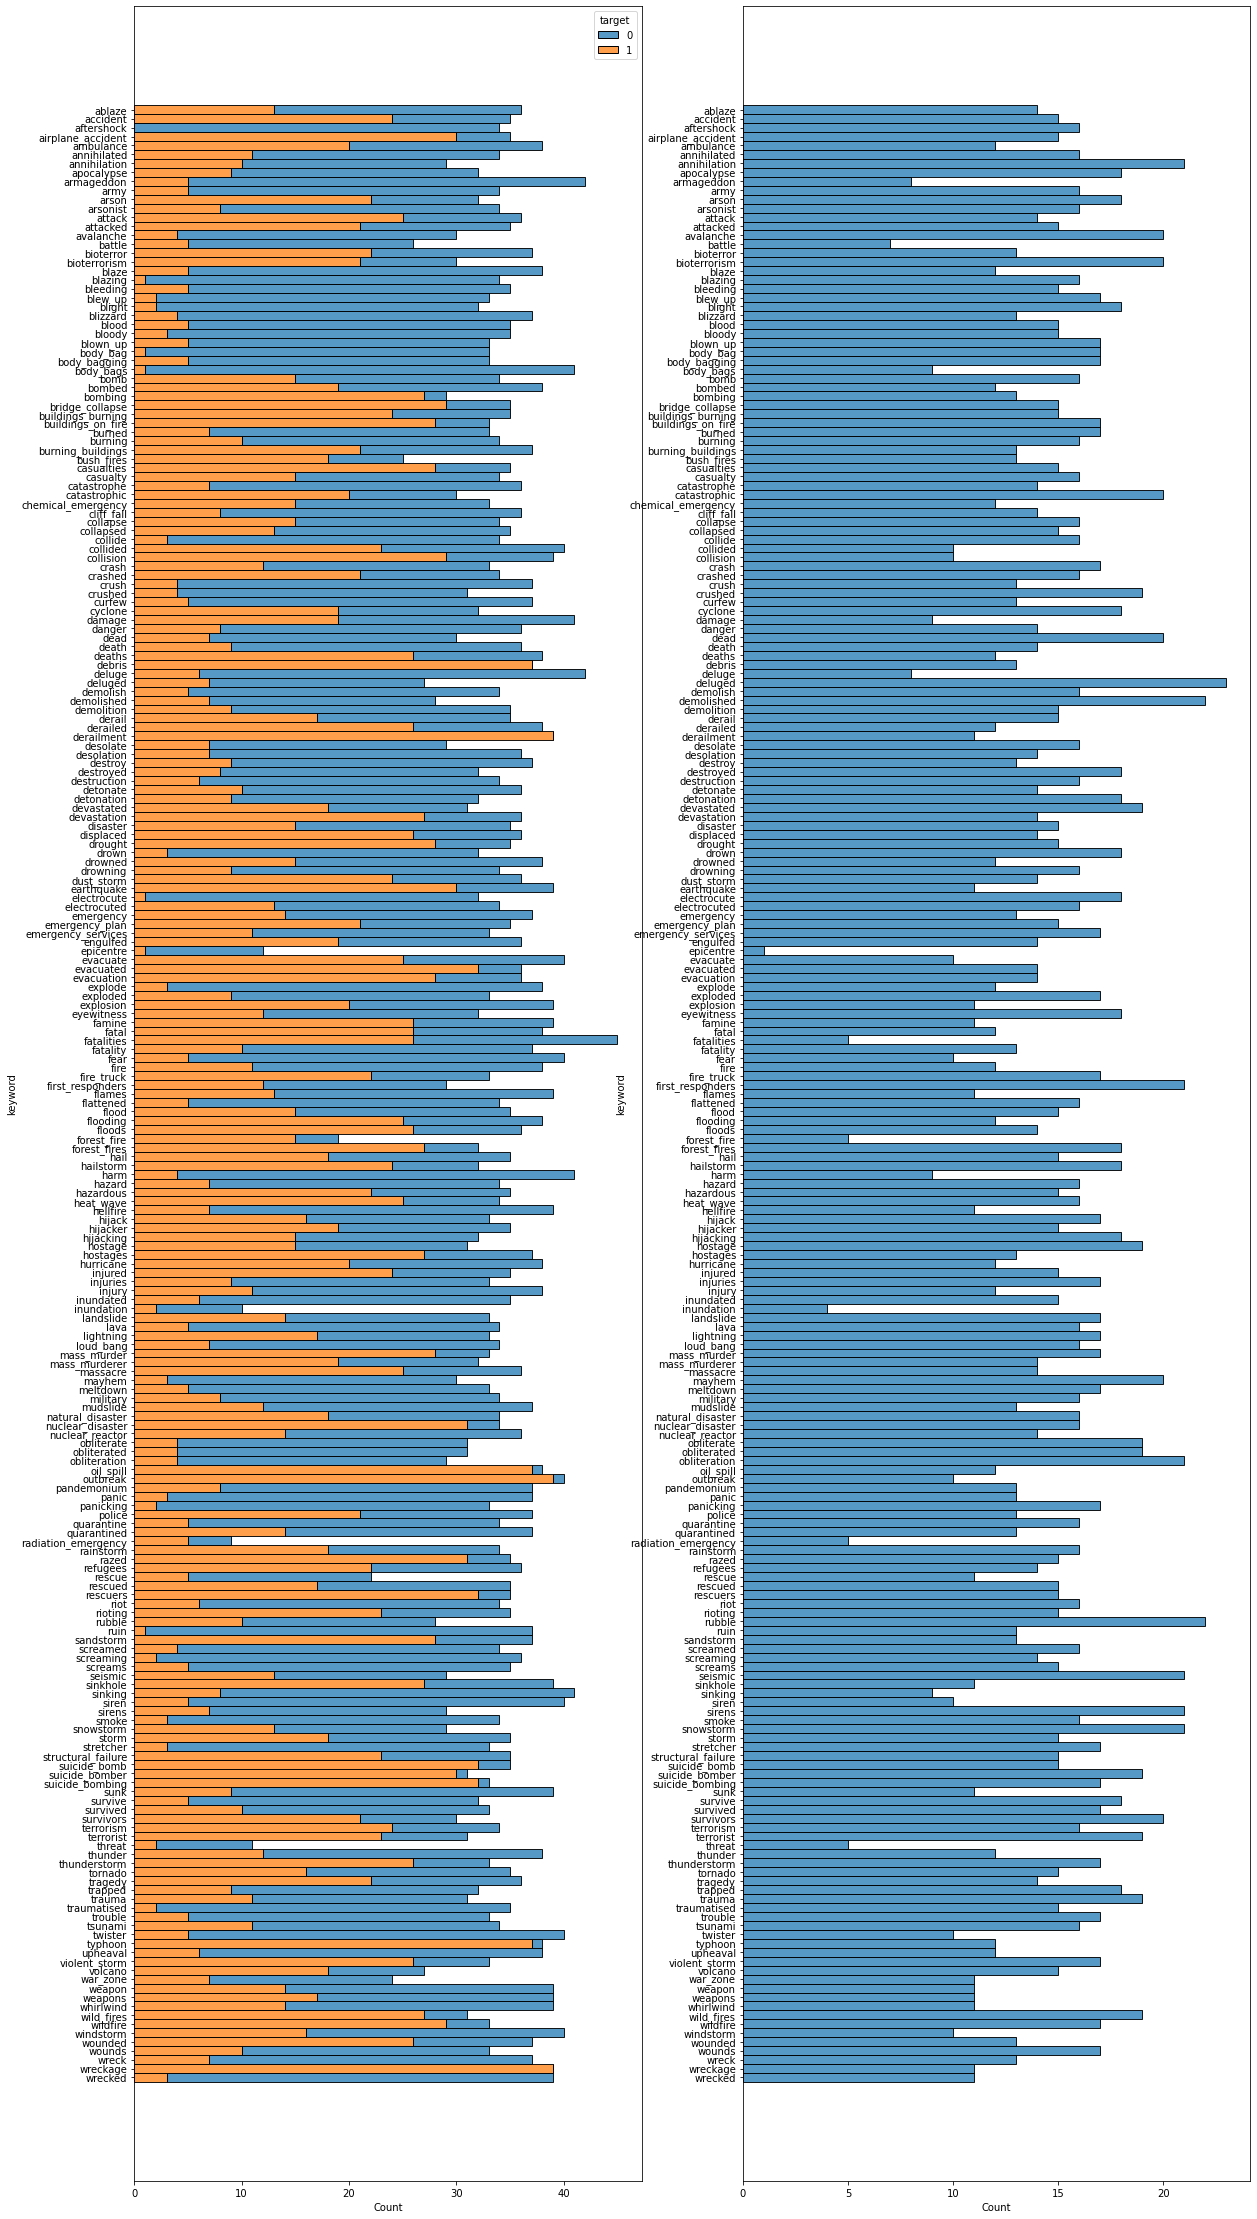

In [7]:
fig,ax=plt.subplots(1,2,figsize=(20,40))
# see train data keyword and its percent on target=0, target=1
sns.histplot(y=train_data['keyword'].sort_values(),hue=train_data['target'],multiple='stack',ax=ax[0])
sns.histplot(y=test_data['keyword'].sort_values(),ax=ax[1]);

In [8]:
#load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

In [9]:
max_length = 72
dataset_for_loader = []
for idx in train_data.index:
    # text encoding
    encoding = tokenizer(
        train_data.loc[idx,'text'],
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True
    )
    # label encoding
    encoding['labels'] = [float(1-train_data.loc[idx,'target']),float(train_data.loc[idx,'target'])]
    encoding = {k: tensor(v) for k, v in encoding.items()}
    dataset_for_loader.append(encoding)

In [10]:
dataset_for_loader

[{'input_ids': tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,  8372,
           2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'labels': tensor([0., 1.])},
 {'input_ids': tensor([  101,  3224,  2543,  2379,  2474,  6902,  3351, 21871,  2243,  1012,
           

In [11]:
dataset_for_eval = []
for idx in test_data.index:
    encoding = tokenizer(
        test_data.loc[idx,'text'],
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True
    )
    encoding = {k: tensor(v) for k, v
                in encoding.items()}
    dataset_for_eval.append(encoding)

In [12]:
dataset_for_eval

[{'input_ids': tensor([ 101, 2074, 3047, 1037, 6659, 2482, 5823,  102,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])},
 {'input_ids': tensor([ 101, 2657, 2055, 1001, 8372, 2003, 2367, 3655, 1010, 2994, 3647, 3071,
          1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    

In [13]:
ids_len = []
for data in dataset_for_loader:
    ids_len.append(sum(data['attention_mask']))
print(max(ids_len))

tensor(72)


#### 3. Model

In [14]:
class BertForSequenceClassification_pl(pl.LightningModule):
    def  __init__(self, model_name, num_labels, lr):
        
        super().__init__()
        
        self.save_hyperparameters()
        
        self.bert_sc = AutoModelForSequenceClassification.from_pretrained(
            model_name,
        )

    def forward(self,x):
        output = self.bert_sc(**x)
        return output
        
    def training_step(self, batch, batch_idx):
        output = self(batch)
        loss = output.loss
#         loss.backward(retain_graph=True)
#         self.log('train_loss', loss)
        with no_grad():
            return loss
        
    def validation_step(self, batch, batch_idx):
        with no_grad():
            output = self(batch)
            loss = output.loss
            self.log('val_loss', loss)
            
    def predict_step(self, batch, batch_idx):
        with no_grad():
            output = self(batch)
            output = output.logits
            s = Softmax()
            output = s(output)
            return output

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.hparams.lr)

In [15]:
# Cross Validation
random.seed(0)
random.shuffle(dataset_for_loader)
random.seed(0)
dataset_idx = train_data.index.values
random.shuffle(dataset_idx)
n = len(dataset_for_loader)
n_train_start_1 = [0,int(1 / 3 * n),int(2 / 3 * n)]
n_train_end_1 = [int(1 / 3 * n),int(2 / 3 * n),n]
n_train_start_2 = [int(1 / 3 * n),int(2 / 3 * n),0]
n_train_end_2 = [int(2 / 3 * n),n,int(1 / 3 * n)]
n_val_start = [int(2 / 3 * n),0,int(1 / 3 * n)]
n_val_end = [n,int(1 / 3 * n),int(2 / 3 * n)]

In [16]:
accelerator = 'gpu' if is_available() else 'cpu'

In [ ]:
for i in range(3):
    dataset_train = dataset_for_loader[n_train_start_1[i]:n_train_end_1[i]] + dataset_for_loader[n_train_start_2[i]:n_train_end_2[i]]
    dataset_val = dataset_for_loader[n_val_start[i]:n_val_end[i]]
    
    dataloader_train = DataLoader(dataset_train, batch_size=16, num_workers=2, pin_memory=True, shuffle=True)
    dataloader_val = DataLoader(dataset_val,batch_size=32, num_workers=2, pin_memory=True)


    # for param in model.named_parameters():
    #     print(param[0],param[1].size())

    earlystopping = pl.callbacks.EarlyStopping(
        monitor='val_loss', 
        min_delta=0, 
        patience=0, 
        verbose=True, 
        mode='min', 
        strict=True, 
        check_finite=True, 
        stopping_threshold=None, 
        divergence_threshold=None, 
        check_on_train_epoch_end=True
    )
#     device_stats = DeviceStatsMonitor(cpu_stats=True)
    trainer = pl.Trainer(
        accelerator=accelerator,
        devices=1,
        max_epochs=10,
#         callbacks=[earlystopping,device_stats],
        callbacks=[earlystopping,],
        default_root_dir=f'../working/model_{i}'
    )


    model = BertForSequenceClassification_pl(model_name=MODEL_NAME, num_labels=2, lr=1e-5)
    trainer.fit(model=model,train_dataloaders=dataloader_train,val_dataloaders=dataloader_val)

    
#     threshold = 0.5

#     dataloader_train = DataLoader(dataset_train, batch_size=128)
#     tensor_pred_train = trainer.predict(model=model,dataloaders=dataloader_train)
#     idx_train = np.concatenate([dataset_idx[n_train_start_1[i]:n_train_end_1[i]],dataset_idx[n_train_start_2[i]:n_train_end_2[i]]])
#     np_pred_train = np.concatenate([p for p in tensor_pred_train])
#     pred_train = (np_pred_train[:,1]>=threshold)*1    
#     df_pred_train = pd.DataFrame(np_pred_train[:,1],index=idx_train,columns=[i])

    
#     dataloader_val = DataLoader(dataset_val,batch_size=128)
#     tensor_pred_val = trainer.predict(model=model,dataloaders=dataloader_val)
#     idx_val = dataset_idx[n_val_start[i]:n_val_end[i]]
#     np_pred_val = np.concatenate([p for p in tensor_pred_val])
#     df_pred_val = pd.DataFrame(np_pred_val[:,1],index=idx_val,columns=[i])
#     df_pred_train_val = pd.concat([df_pred_train,df_pred_val],axis=0)
#     df_pred_train_val.to_csv(f'../working/train_val_proba_{i}.csv')
    
#     y_train = [dataset['labels'][1].tolist() for dataset in dataset_train]
#     y_val = [dataset['labels'][1].tolist() for dataset in dataset_val]

#     pred_val = (np_pred_val[:,1]>=threshold)*1    


#     print(classification_report(y_train,pred_train))
#     print(classification_report(y_val,pred_val))

#     print(confusion_matrix(y_train,pred_train))
#     print(confusion_matrix(y_val,pred_val))
#     print(device_stats)

#     models.append(model)
#    thresholds.append(threshold)
    with open(f'../working/model_{i}.pkl', mode='wb') as f:
        pickle.dump(model,f)
#     del trainer,model
#     gc.collect()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.396


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 1 records. Best score: 0.396. Signaling Trainer to stop.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.399


In [ ]:
https://www.kaggle.com/code/ohba0321/nlp-with-disaster-pytorch-lightning-and-bertweet